In [1]:
import os
import sys
import torch
import numpy as np

from matplotlib import pyplot as plt
from conditional_rate_matching.utils.plots.images_plots import mnist_grid,mnist_noise_bridge
from conditional_rate_matching.configs.experiments_configs.crm.crm_experiments_nist import experiment_nist

from conditional_rate_matching.models.generative_models.crm import CRM
from conditional_rate_matching.configs.configs_classes.config_crm import CRMConfig

from conditional_rate_matching.models.pipelines.sdes_samplers.samplers import TauLeaping,TauLeapingRates
from torchvision.utils import make_grid
from conditional_rate_matching.data.image_dataloader_config import NISTLoaderConfig

from conditional_rate_matching.models.metrics.crm_path_metrics import conditional_bridge_marginal_probabilities_and_rates_path,conditional_bridge_images

# metrics
from conditional_rate_matching.models.metrics.histograms import binary_histogram_dataloader
from conditional_rate_matching.models.metrics.crm_path_metrics import telegram_bridge_sample_paths

# plots
from conditional_rate_matching.utils.plots.histograms_plots import plot_marginals_binary_histograms
from conditional_rate_matching.utils.plots.paths_plots import rates_plot

from conditional_rate_matching.models.pipelines.thermostat.crm_thermostat import ExponentialThermostat,LogThermostat,InvertedExponentialThermostat

from pprint import pprint
from conditional_rate_matching import plots_path

/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/tqdm-4.66.1-py3.10.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from conditional_rate_matching.models.pipelines.thermostat.thermostat_utils import load_thermostat,LogThermostatConfig

In [3]:
from conditional_rate_matching import plots_path

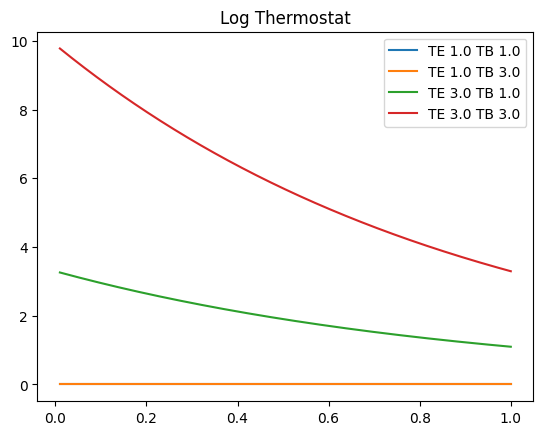

In [4]:
config = CRMConfig()
time_exponential = 3.
time_base = 1.

save_dir = os.path.join(plots_path,"log_thermostat.png")

for time_exponential in [1.,3.]:
    for time_base in [1.,3.]:
        config.thermostat = LogThermostatConfig(time_base=time_base,time_exponential=time_exponential)
        
        thermostat = load_thermostat(config)
        time = torch.linspace(0.01,1.,1000)
        values = thermostat(time)
        plt.plot(time,values,label="TE {0} TB {1}".format(time_exponential,time_base))
plt.title("Log Thermostat")
plt.legend(loc="best")
plt.savefig(save_dir)

In [5]:
from dataclasses import dataclass

@dataclass
class ExponentialThermostatConfig:
    name:str="LogThermostat"
    max:float = 10.
    gamma:float = 10.


class ExponentialThermostat:

    def __init__(self,config:ExponentialThermostatConfig):
        self.max = config.max
        self.gamma = config.gamma

    def _integral_rate_scalar(self, t):
        raise Exception

    def __call__(self, t):
        device = t.device
        thermostat = torch.exp(-self.gamma*torch.abs(t-0.5))*self.max
        return thermostat.to(device)

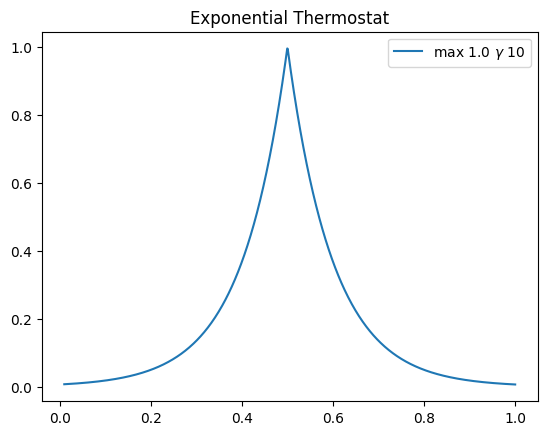

In [37]:
max = 1.
gamma= 10
exp_config = ExponentialThermostatConfig(max=max,gamma=gamma)
thermostat = ExponentialThermostat(exp_config)
values = thermostat(time)
save_dir = os.path.join(plots_path,"exp_thermostat.png")

plt.title("Exponential Thermostat")
plt.plot(time,values,label=r"max {0} $\gamma$ {1}".format(max,gamma))
plt.legend(loc="best")
plt.savefig(save_dir)

In [7]:
from dataclasses import dataclass

@dataclass
class InvertedExponentialThermostatConfig:
    name:str="InvertedExponentialThermostat"
    max:float = 10.
    gamma:float = 10.


class InvertedExponentialThermostat:

    def __init__(self,config:ExponentialThermostatConfig):
        self.max = config.max
        self.gamma = config.gamma

    def _integral_rate_scalar(self, t):
        raise Exception

    def __call__(self, t):
        device = t.device
        thermostat = torch.exp(-self.gamma*(t-0.5)) + torch.exp(self.gamma*(t-0.5))
        thermostat = thermostat/torch.exp(-self.gamma*(-torch.Tensor([0.5]))) + torch.exp(self.gamma*(-torch.Tensor([0.5])))
        thermostat = thermostat*self.max
        return thermostat.to(device)

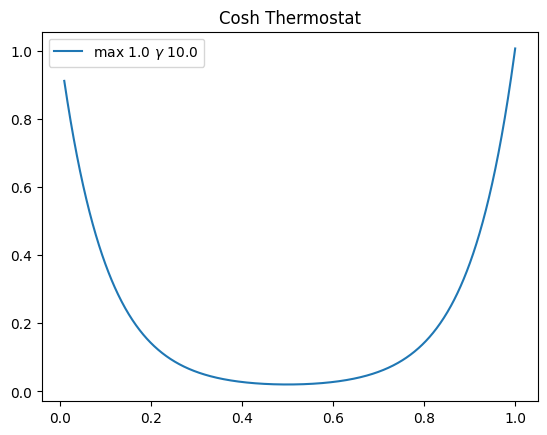

In [8]:
max = 1.
gamma=10.

exp_config = InvertedExponentialThermostatConfig(max=max,gamma=gamma)
thermostat = InvertedExponentialThermostat(exp_config)

values = thermostat(time)
save_dir = os.path.join(plots_path,"inv_exp_thermostat.png")

plt.title("Cosh Thermostat")
plt.plot(time,values,label=r"max {0} $\gamma$ {1}".format(max,gamma))
plt.legend(loc="best")
plt.savefig(save_dir)

In [45]:
from dataclasses import dataclass

@dataclass
class TriangleThermostatConfig:
    name:str="TriangleThermostat"
    max:float = 10.
    gamma:float = 10.


class TriangleThermostat:

    def __init__(self,config:TriangleThermostatConfig):
        self.max = config.max
        self.gamma = config.gamma

    def _integral_rate_scalar(self, t):
        raise Exception

    def __call__(self, t):
        device = t.device
        thermostat = self.max - 2 * self.max * np.abs(t - 0.5)
        return thermostat.to(device)

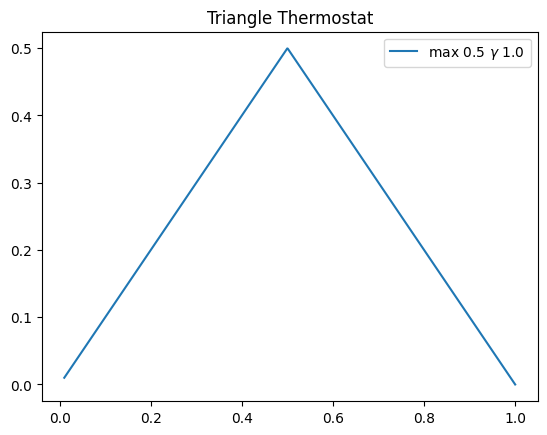

In [47]:
max = 0.5
gamma=1.

exp_config = TriangleThermostatConfig(max=max,gamma=gamma)
thermostat = TriangleThermostat(exp_config)

values = thermostat(time)
save_dir = os.path.join(plots_path,"triangle_thermostat.png")

plt.title("Triangle Thermostat")
plt.plot(time,values,label=r"max {0} $\gamma$ {1}".format(max,gamma))
plt.legend(loc="best")
plt.savefig(save_dir)